In [365]:
import pandas as pd

df = pd.read_csv('imoveis.csv')


In [366]:
df_venda = df[df['operacao'] == 'venda'].reset_index(drop=True)
df_aluguel = df[df['operacao'] == 'aluguel'].reset_index(drop=True)

## Precificador de Venda

In [367]:
df_venda = df_venda.drop(['iptu','condominio','imobiliaria', 'creci', 'regiao', 'Título', 'operacao', 'Valor_metro'], axis=1)
df_venda



,Valor,area,quartos,suites,garagem,cidade,Aquecimento Solar,Circuito de TV,Gerador de Energia,Piscina,...,Salão Gourmet,Sauna,SPA,Área de Serviço Coberta,Piso em Porcelanato,Vista Livre,Home Theater,Aceita Pet,Academia,tipo
0,2290000.0,147.00,4,2,2,BRASÍLIA - SUDOESTE,0,0,0,1,...,0,1,0,0,0,1,0,0,0,Apartamento
1,6900000.0,750.00,5,5,4,BRASÍLIA - LAGO SUL,1,0,0,1,...,0,1,0,0,0,0,0,0,0,Casa
2,4900000.0,583.00,4,4,3,BRASÍLIA - LAGO SUL,1,0,0,1,...,0,1,0,0,0,0,0,0,0,Casa
3,1290000.0,473.95,5,3,6,BRASÍLIA - JARDIM BOTANICO,1,0,0,1,...,0,0,0,0,0,1,0,0,0,Casa
4,2490000.0,177.00,3,1,0,BRASÍLIA - ASA SUL,0,0,0,0,...,0,0,0,0,0,1,0,0,0,Apartamento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41900,45000.0,12.00,0,0,1,BRASÍLIA - ASA SUL,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Garagem
41901,695000.0,0.00,0,0,0,ÁGUAS CLARAS - ARNIQUEIRA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,Lote/Terreno/Área
41902,1000.0,300.00,0,0,0,TAGUATINGA - TAGUATINGA SUL,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Lote/Terreno/Área
41903,2700.0,26.00,1,1,1,BRASÍLIA - ASA NORTE,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Kitnet


In [368]:
excluir = []
somatorios = df_venda.sum()
for i,j in enumerate(df_venda.columns):
    if type(somatorios.iloc[i]) == str:
        pass
    elif somatorios.iloc[i] < 0.2*df_venda.shape[0]:
        excluir.append(j)



In [369]:
df_venda = df_venda.drop(excluir,axis=1)

In [370]:
df_venda = pd.get_dummies(df_venda)

In [371]:
# Identificar e remover outliers na variável alvo (valor do imóvel)
Q1 = df_venda['Valor'].quantile(0.25)
Q3 = df_venda['Valor'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
df_venda = df_venda[(df_venda['Valor'] > limite_inferior) & (df_venda['Valor'] < limite_superior)]

In [372]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Suponha que você tenha um DataFrame df com suas colunas X e y
# Exemplo de DataFrame
df = df_venda

# Separando os recursos (X) e os rótulos (y)
X = df.drop('Valor', axis=1) # Recursos
y = df['Valor']    # Rótulos


# Separando os dados em conjuntos de treinamento, teste e validação
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Inicialize o MinMaxScaler para X
scaler_X = MinMaxScaler()
X_train_normalized = scaler_X.fit_transform(X_train)
X_test_normalized = scaler_X.transform(X_test)
X_val_normalized = scaler_X.transform(X_val)

# Inicialize o MinMaxScaler para y
scaler_y = MinMaxScaler()
y_train_normalized = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_normalized = scaler_y.transform(y_test.values.reshape(-1, 1))
y_val_normalized = scaler_y.transform(y_val.values.reshape(-1, 1))

# Exiba os tamanhos dos conjuntos de dados
print("Tamanho do conjunto de treinamento:", len(X_train_normalized))
print("Tamanho do conjunto de teste:", len(X_test_normalized))
print("Tamanho do conjunto de validação:", len(X_val_normalized))


Tamanho do conjunto de treinamento: 31334
Tamanho do conjunto de teste: 3917
Tamanho do conjunto de validação: 3917


In [373]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Supondo que você já tenha X_train, y_train, X_val, y_val definidos e normalizados

# Criando a rede neural para regressão
model = Sequential([
    Input(shape=(X_train_normalized.shape[1],)),  # Definindo explicitamente a camada de entrada com 30 features
    Dense(64, activation='relu'),  # Primeira camada oculta com 64 neurônios e ativação ReLU
    Dense(64, activation='relu'),  # Segunda camada oculta
    Dense(64, activation='relu'),  # Terceira camada oculta
    Dense(64, activation='relu'),  # Quarta camada oculta
    Dense(1,  activation='relu')  # Camada de saída para regressão
])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Compilando o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinando o modelo
history = model.fit(X_train_normalized, y_train_normalized, validation_data=(X_val_normalized, y_val_normalized), epochs=100, verbose=1, callbacks=[reduce_lr, early_stopping])


Epoch 1/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 958us/step - loss: 0.0330 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 2/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - loss: 0.0175 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 3/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - loss: 0.0155 - val_loss: 0.0158 - learning_rate: 0.0010
Epoch 4/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - loss: 0.0148 - val_loss: 0.0164 - learning_rate: 0.0010
Epoch 5/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - loss: 0.0145 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 6/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - loss: 0.0144 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 7/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - loss: 0.0138 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 8/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - loss: 0.0135 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 9/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - loss: 0.0133 - val_loss: 0.0158 - learn

In [374]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prevendo os valores para o conjunto de teste
y_pred_normalized = model.predict(X_test_normalized)

# Desnormalizando os valores previstos
y_pred = scaler_y.inverse_transform(y_pred_normalized)

# Calculando métricas de regressão com os dados desnormalizados
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
MSE: 138297277994.61377
MAE: 239141.33292728412
R^2: 0.6984850438521243


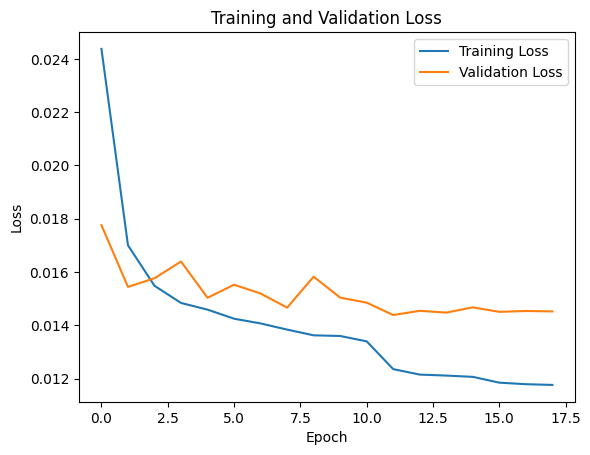

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step


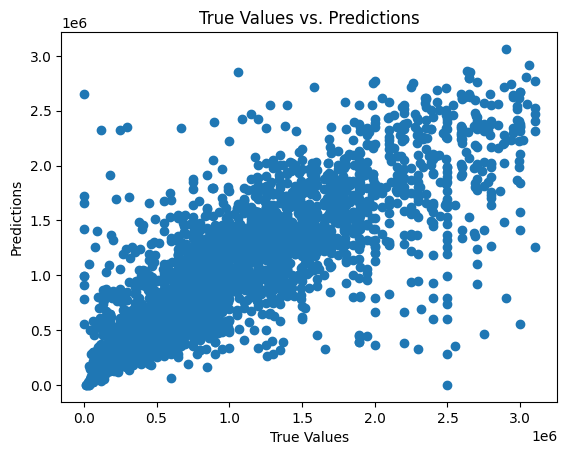

In [375]:
import numpy as np
import matplotlib.pyplot as plt

# Plotando os resultados do treinamento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Prevendo os valores para o conjunto de teste
y_pred_normalized = model.predict(X_test_normalized)

# Desnormalizando os valores previstos
y_pred = scaler_y.inverse_transform(y_pred_normalized)

# Plotando os resultados da previsão
plt.scatter(y_test, y_pred, label='True Values')  # Valores reais como pontos
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs. Predictions')

plt.show()

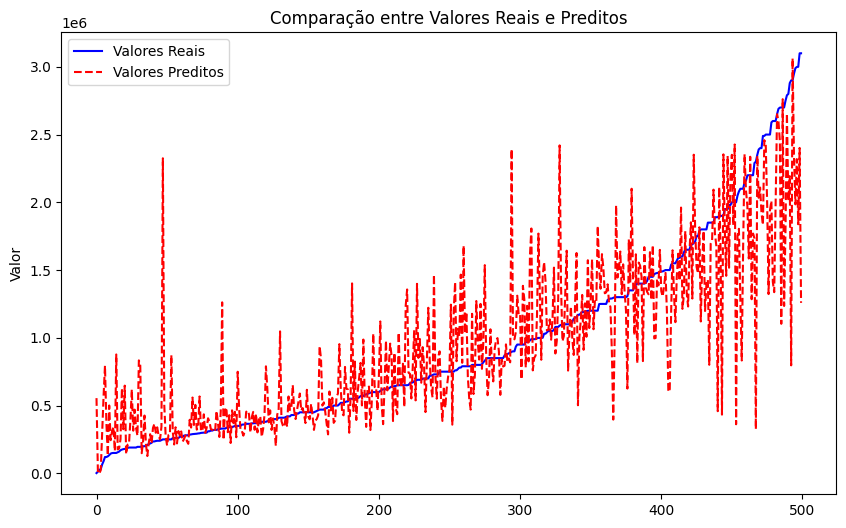

In [376]:
# Supondo que 'y_pred_desnorm' e 'y_test_desnorm' sejam os arrays com os valores preditos e reais desnormalizados
import pandas as pd

# Criando um DataFrame com os valores preditos e reais
df_results = pd.DataFrame({'Valores Reais': y_test, 'Valores Preditos': y_pred.flatten()})
df_results = df_results.sample(frac=1, random_state=70)
df_results = df_results[:500]
# Ordenando o DataFrame pelos valores reais
df_results_sorted = df_results.sort_values('Valores Reais').reset_index(drop=True)

# Plotando os valores reais e os preditos
plt.figure(figsize=(10, 6))
plt.plot(df_results_sorted.index, df_results_sorted['Valores Reais'], label='Valores Reais', color='blue')
plt.plot(df_results_sorted.index, df_results_sorted['Valores Preditos'], label='Valores Preditos', color='red', linestyle='--')
plt.title('Comparação entre Valores Reais e Preditos')
plt.ylabel('Valor')
plt.legend()
plt.show()

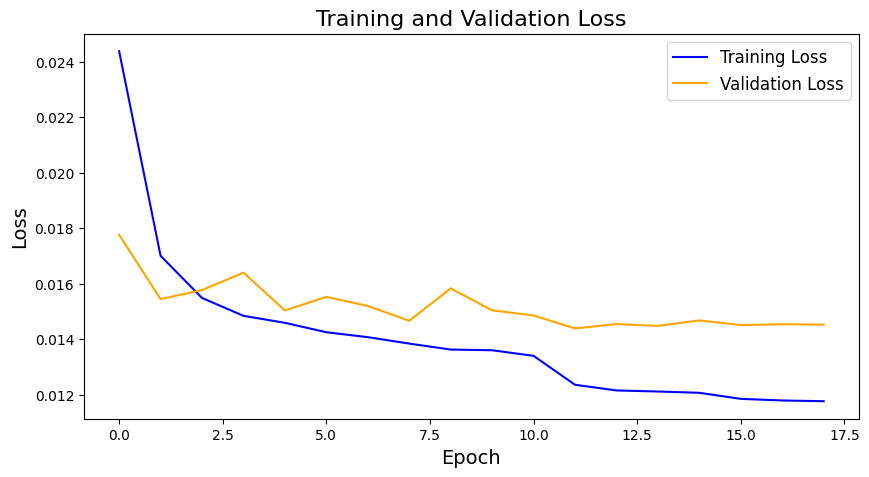

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step


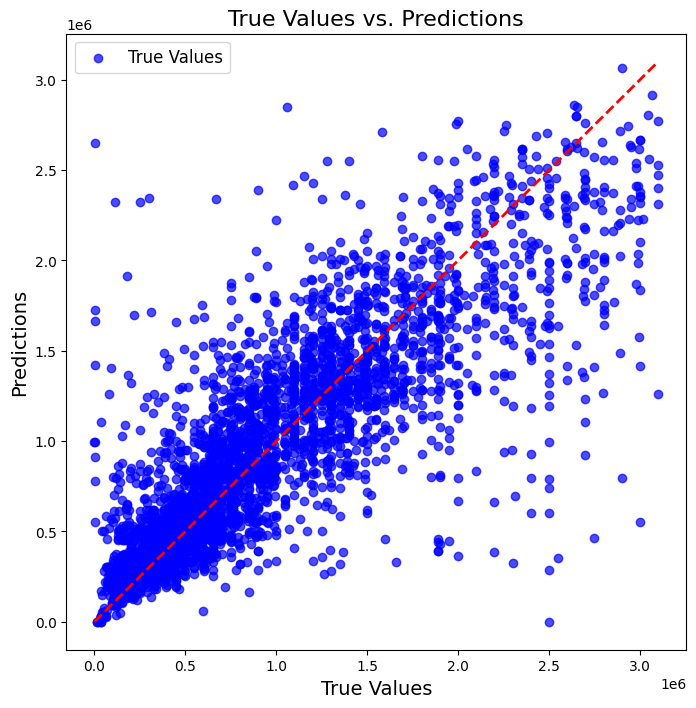

In [377]:
import numpy as np
import matplotlib.pyplot as plt

# Plotando os resultados do treinamento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.legend(fontsize=12)
plt.show()

# Prevendo os valores para o conjunto de teste
y_pred_normalized = model.predict(X_test_normalized)

# Desnormalizando os valores previstos
y_pred = scaler_y.inverse_transform(y_pred_normalized)

# Plotando os resultados da previsão
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, label='True Values', color='blue', alpha=0.7)  # Valores reais como pontos
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)  # Linha de 45 graus
plt.xlabel('True Values', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.title('True Values vs. Predictions', fontsize=16)
plt.legend(fontsize=12)
plt.show()
